In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monthly-sunspots/monthly-sunspots.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index("Month")
    
    # resample the time to 2 Months
    df = df["Sunspots"].resample("2M").mean().fillna(method="ffill").to_frame()
    
    # create df[p2.l1] that will be the shift of p2
    df["Sunspots.L1"] = df["Sunspots"].shift(1)     #.dropna(inplace=True)
    df.dropna(inplace=True)
    
    
    return df

In [4]:
df = wrangle("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
df.head()

,Sunspots,Sunspots.L1
Month,,
1749-03-31,66.30,58.00
1749-05-31,70.35,66.30
1749-07-31,89.15,70.35
1749-09-30,71.10,89.15
1749-11-30,117.05,71.10


In [5]:
df.isnull().sum()

Sunspots       0
Sunspots.L1    0
dtype: int64

<AxesSubplot:>

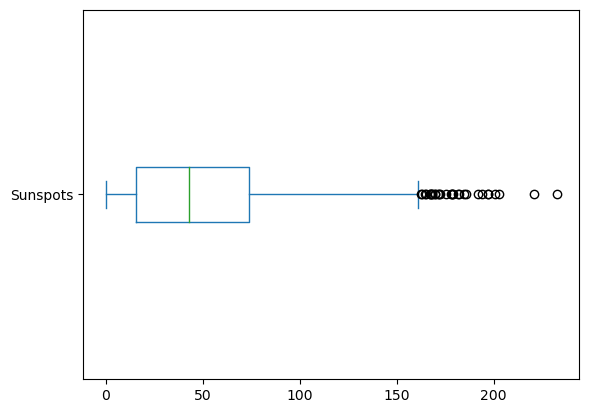

In [6]:
df["Sunspots"].plot(kind="box", vert = False)

In [7]:
df.shape

(1410, 2)

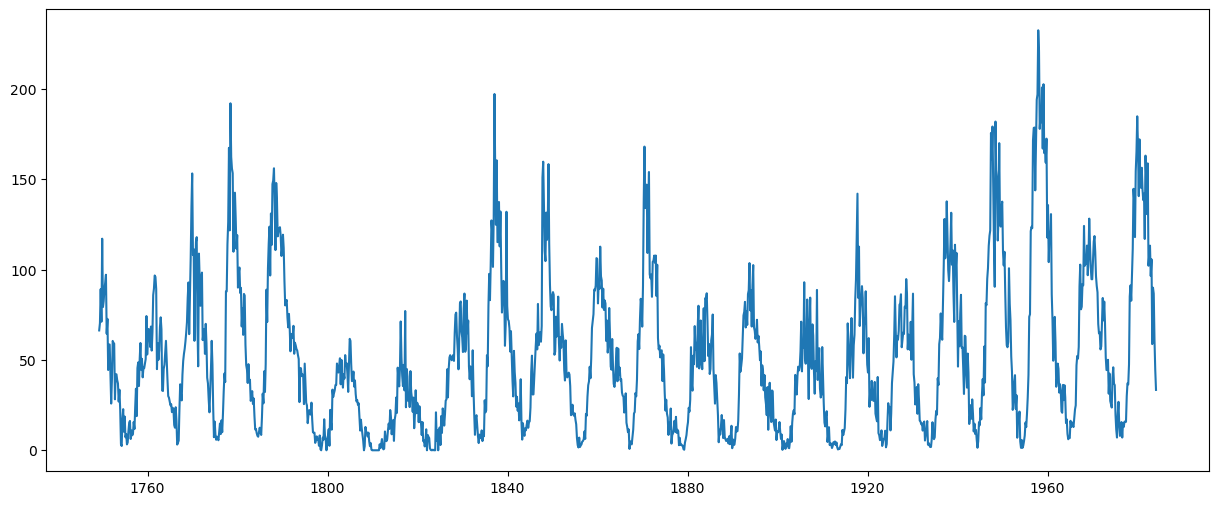

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df["Sunspots"])

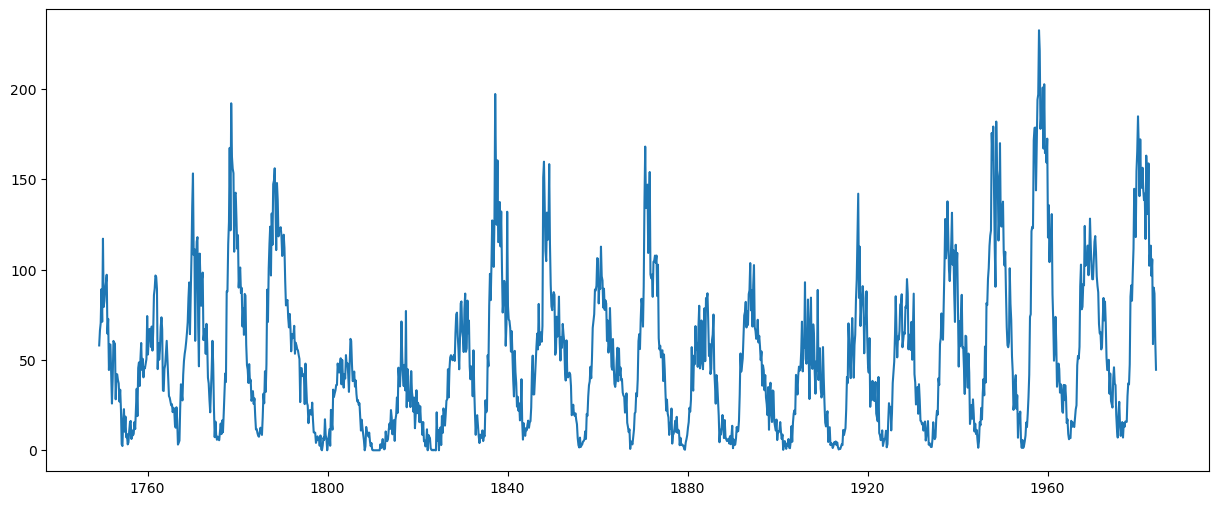

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df["Sunspots.L1"])

In [10]:
df_dummy = df["Sunspots"].resample("5M").mean()
df_dummy.head()

Month
1749-03-31    66.300000
1749-08-31    79.750000
1750-01-31    89.133333
1750-06-30    85.850000
1750-11-30    84.766667
Freq: 5M, Name: Sunspots, dtype: float64

In [11]:
df_dummy.shape

(565,)

> Here the question arises that, since the data is already in Months,means a single observation is an observation of whole month, so whether we should resample it or not

<AxesSubplot:xlabel='Month'>

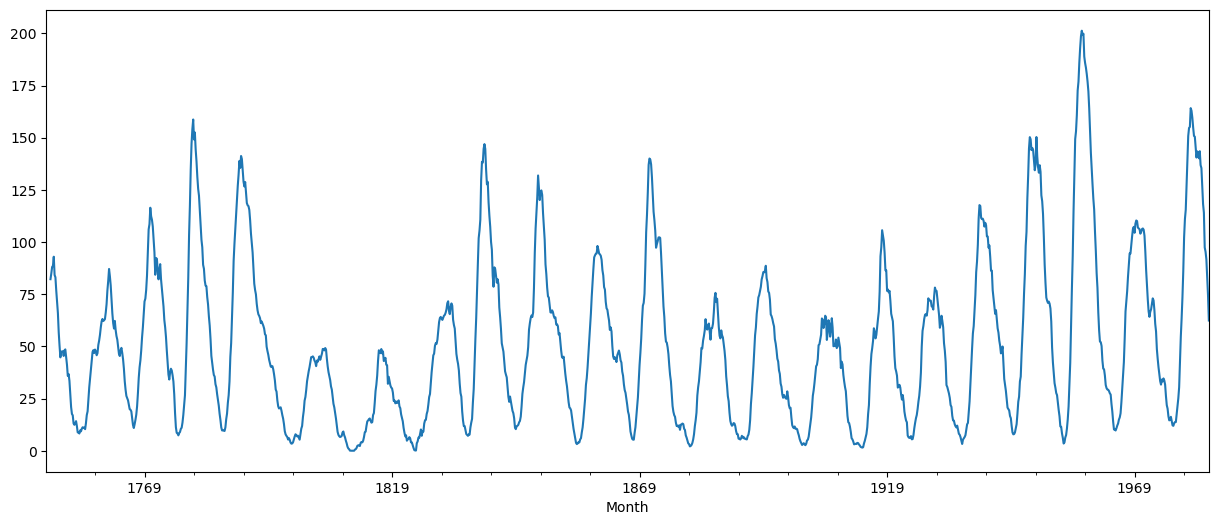

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sunspots"].rolling(6).mean().plot(ax=ax)

<AxesSubplot:xlabel='Month'>

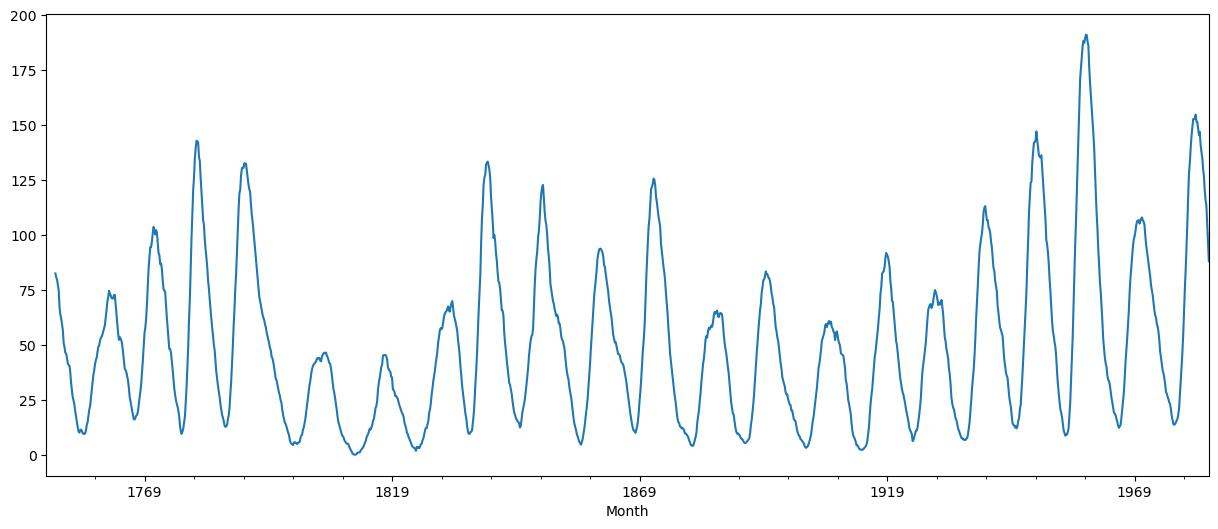

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sunspots"].rolling(12).mean().plot(ax=ax)

In [14]:
df.corr()

,Sunspots,Sunspots.L1
Sunspots,1.000000,0.931787
Sunspots.L1,0.931787,1.000000


In [15]:
#df.corr(df["Sunspots.L1"].shift(1))

In [16]:
df_dummy = pd.read_csv("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
df_dummy["Sunspots.L2"] = df_dummy["Sunspots"].shift(2)
df_dummy["Sunspots.L1"] = df_dummy["Sunspots"].shift(1)
df_dummy.corr()

,Sunspots,Sunspots.L2,Sunspots.L1
Sunspots,1.000000,0.890541,0.921718
Sunspots.L2,0.890541,1.000000,0.921713
Sunspots.L1,0.921718,0.921713,1.000000


In [17]:
df.head()

,Sunspots,Sunspots.L1
Month,,
1749-03-31,66.30,58.00
1749-05-31,70.35,66.30
1749-07-31,89.15,70.35
1749-09-30,71.10,89.15
1749-11-30,117.05,71.10


In [18]:
df["Sunspots.L1"].shape

(1410,)

In [19]:
df["Sunspots"].shape

(1410,)

# **Split**

In [20]:
target = "Sunspots"
y = df[target]
X = df.drop(columns=target)

In [21]:
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [22]:
X_train.head()

,Sunspots.L1
Month,
1749-03-31,58.00
1749-05-31,66.30
1749-07-31,70.35
1749-09-30,89.15
1749-11-30,71.10


In [23]:
y_train.head()

Month
1749-03-31     66.30
1749-05-31     70.35
1749-07-31     89.15
1749-09-30     71.10
1749-11-30    117.05
Freq: 2M, Name: Sunspots, dtype: float64

In [24]:
X_train.shape

(1128, 1)

In [25]:
y_train.shape

(1128,)

# **Build Model**

In [26]:
y_pred_baseline = [(y_train.mean())] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 44.7
Baseline MAE: 29.11


In [27]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [28]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 10.35
Test MAE: 13.91


> We are getting mae less that that of baseline, so for now we are good to go

# **AutoRegressive Model**

> Wrangle function for autoregression

In [29]:
def wrangle_for_ar(filepath):
    df = pd.read_csv(filepath)
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index("Month")
    
    # resample the time to 2 Months
    df = df["Sunspots"].resample("1M").mean().fillna(method="ffill")
    
    # create df[p2.l1] that will be the shift of p2
    #df["Sunspots.L1"] = df["Sunspots"].shift(1)     #.dropna(inplace=True)
    #df.dropna(inplace=True)
    
    
    return df

In [30]:
y = wrangle_for_ar("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
y.head()

Month
1749-01-31    58.0
1749-02-28    62.6
1749-03-31    70.0
1749-04-30    55.7
1749-05-31    85.0
Freq: M, Name: Sunspots, dtype: float64

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

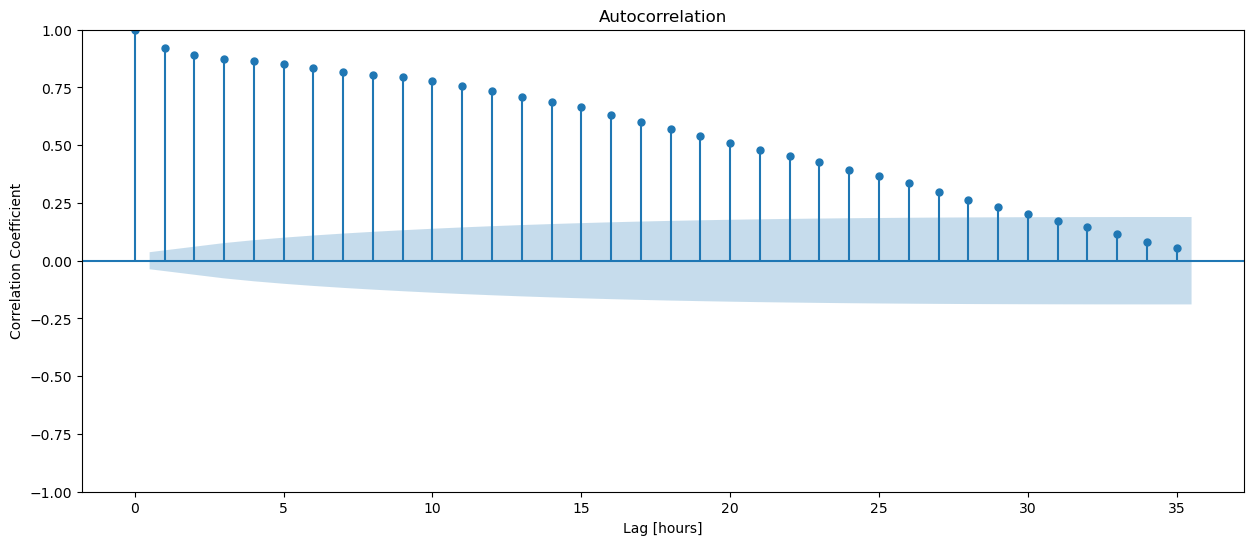

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

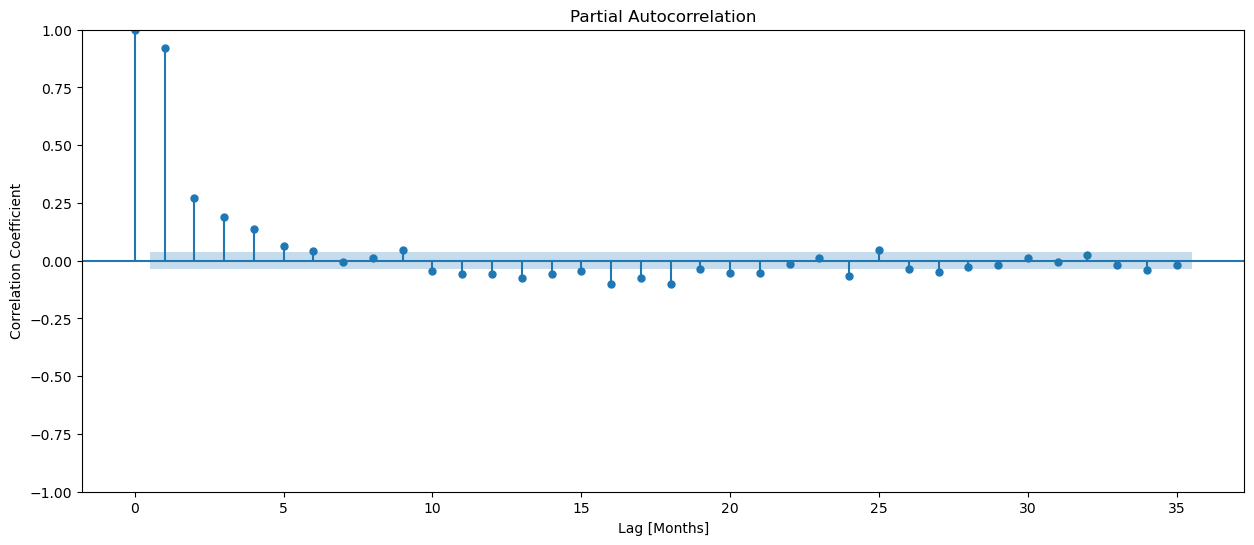

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, method = 'ywm', ax=ax)
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation Coefficient");

**Split**

In [34]:
cutoff_test = int(len(y) * 0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

len(y_train) + len(y_test) == len(y)

True

In [35]:
y_train.head()

Month
1749-01-31    58.0
1749-02-28    62.6
1749-03-31    70.0
1749-04-30    55.7
1749-05-31    85.0
Freq: M, Name: Sunspots, dtype: float64

In [36]:
y_train.isnull().sum()

0

# # # > > **Build Model**

In [37]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 49.92
Baseline MAE: 33.49


In [38]:
model = AutoReg(y_train, lags=24).fit()

In [39]:
y_train_pred = model.predict()
y_train_pred.head()

Month
1749-01-31   NaN
1749-02-28   NaN
1749-03-31   NaN
1749-04-30   NaN
1749-05-31   NaN
Freq: M, dtype: float64

In [40]:
y_train_pred.shape

(2679,)

In [41]:
y_train.shape

(2679,)

In [42]:
y_train_pred.isnull().sum()

24

In [43]:
y_train_pred_drop = model.predict().dropna()
y_train_pred_drop.head()

Month
1751-01-31    77.108516
1751-02-28    77.027112
1751-03-31    54.742449
1751-04-30    55.411211
1751-05-31    55.905793
Freq: M, dtype: float64

In [44]:
y_train_pred_drop.isnull().sum()

0

In [45]:
training_mae_ar = mean_absolute_error(y_train.iloc[26:], y_train_pred.iloc[26:])
print("Training MAE:", training_mae_ar)

Training MAE: 10.689101281263031


In [46]:
y_train_resid = y_train - y_train_pred#model.resid
y_train_resid.tail()

Month
1971-11-30    14.377063
1971-12-31    27.691989
1972-01-31    -4.317611
1972-02-29    35.714786
1972-03-31    12.391545
Freq: M, dtype: float64

In [47]:
y_train_resid = model.resid
y_train_resid.tail()

Month
1971-11-30    14.377063
1971-12-31    27.691989
1972-01-31    -4.317611
1972-02-29    35.714786
1972-03-31    12.391545
Freq: M, dtype: float64

<AxesSubplot:xlabel='Month'>

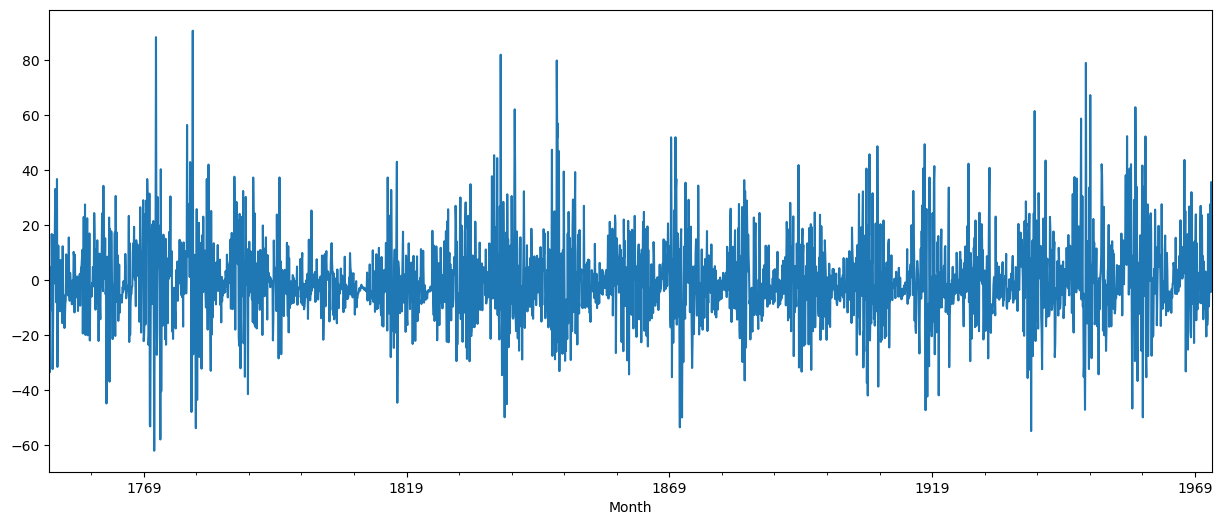

In [48]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax)

<AxesSubplot:ylabel='Frequency'>

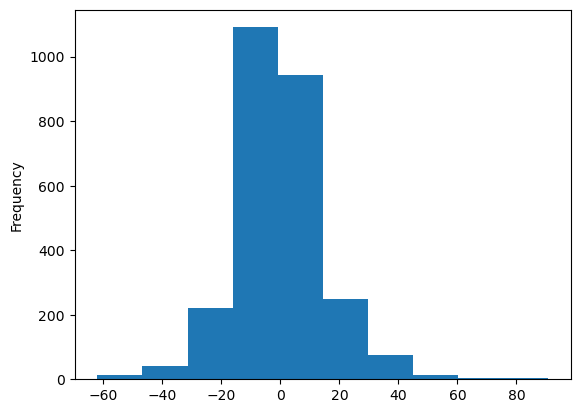

In [49]:
y_train_resid.plot(kind="hist")

In [50]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 46.64557229639959


In [51]:
%%capture

y_pred_wfv = pd.Series()  #not list because you also have to store timestamp as well
history = y_train.copy()  #the training data on which we have to make prediction and that will be increase as we start making predictions
for i in range(len(y_test)):
    model = AutoReg(history, lags = 24).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    


In [52]:
history = y_train.copy()
history.tail(1)

Month
1972-03-31    80.1
Freq: M, Name: Sunspots, dtype: float64

In [53]:
y_test.head(1)

Month
1972-04-30    63.2
Freq: M, Name: Sunspots, dtype: float64

In [54]:
model = AutoReg(history, lags = 26).fit()

In [55]:
model.forecast()

1972-04-30    70.648975
Freq: M, dtype: float64

In [56]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 14.21


> # **ARMA Model**

In [57]:
def wrangle_for_arma(filepath):
    df = pd.read_csv(filepath)
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index("Month")
    
    # resample the time to 2 Months
    df = df["Sunspots"].resample("1M").mean().fillna(method="ffill")
    
    # create df[p2.l1] that will be the shift of p2
    #df["Sunspots.L1"] = df["Sunspots"].shift(1)     #.dropna(inplace=True)
    #df.dropna(inplace=True)
    
    
    return df

In [58]:
y_arma = wrangle_for_arma("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
y_arma.head()

Month
1749-01-31    58.0
1749-02-28    62.6
1749-03-31    70.0
1749-04-30    55.7
1749-05-31    85.0
Freq: M, Name: Sunspots, dtype: float64

In [59]:
y_arma.tail(20)

Month
1982-05-31     82.2
1982-06-30    110.4
1982-07-31    106.1
1982-08-31    107.6
1982-09-30    118.8
1982-10-31     94.7
1982-11-30     98.1
1982-12-31    127.0
1983-01-31     84.3
1983-02-28     51.0
1983-03-31     66.5
1983-04-30     80.7
1983-05-31     99.2
1983-06-30     91.1
1983-07-31     82.2
1983-08-31     71.8
1983-09-30     50.3
1983-10-31     55.8
1983-11-30     33.3
1983-12-31     33.4
Freq: M, Name: Sunspots, dtype: float64

In [60]:
y_arma.shape

(2820,)

start_time = '1749-01-31'
end_time = '1749-05-31'
#y_arma.get(y_arma.iloc[start_time: end_time])
specific_period_data = y_arma.loc[start_time:end_time]
specific_period_data

In [61]:
y_arma.get('1749')

Month
1749-01-31     58.0
1749-02-28     62.6
1749-03-31     70.0
1749-04-30     55.7
1749-05-31     85.0
1749-06-30     83.5
1749-07-31     94.8
1749-08-31     66.3
1749-09-30     75.9
1749-10-31     75.5
1749-11-30    158.6
1749-12-31     85.2
Freq: M, Name: Sunspots, dtype: float64

In [62]:
start_time = '1950' 
end_time = '1980' 
#y_arma.get(y_arma.iloc[start_time: end_time]) 
specific_period_data_train = y_arma.loc[start_time:end_time] 
specific_period_data_train

Month
1950-01-31    101.6
1950-02-28     94.8
1950-03-31    109.7
1950-04-30    113.4
1950-05-31    106.2
              ...  
1980-08-31    135.4
1980-09-30    155.0
1980-10-31    164.7
1980-11-30    147.9
1980-12-31    174.4
Freq: M, Name: Sunspots, Length: 372, dtype: float64

In [63]:
specific_period_data_train.shape

(372,)

In [64]:
start_time = '1981' 
end_time = '1983' 
#y_arma.get(y_arma.iloc[start_time: end_time]) 
specific_period_data_test = y_arma.loc[start_time:end_time] 
specific_period_data_test.head()

Month
1981-01-31    114.0
1981-02-28    141.3
1981-03-31    135.5
1981-04-30    156.4
1981-05-31    127.5
Freq: M, Name: Sunspots, dtype: float64

In [65]:
y_train_arma = specific_period_data_train#y.get("2018-10")
y_test_arma = specific_period_data_test#y.get("2018-11-1")

In [66]:
p_params = range(0,18, 6)
q_params = range(0,3,1)

> Hyperparameter tuning and arma model

In [67]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
import time

In [69]:
model_arma = ARIMA(y_train_arma, order = (0, 0, 0)).fit()


In [70]:
y_pred_arma = model_arma.predict()
y_pred_arma.shape

(372,)

In [71]:
y_train_mean_arma = y_train_arma.mean()
y_pred_baseline_arma = [y_train_mean_arma] * len(y_train_arma)
mae_baseline_arma = mean_absolute_error(y_train_arma, y_pred_baseline_arma)
print("Mean P2 Reading:", round(y_train_mean_arma, 2))
print("Baseline MAE:", round(mae_baseline_arma, 2))

Mean P2 Reading: 74.07
Baseline MAE: 48.22


In [72]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model_arma = ARIMA(y_train_arma, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
#         if not model_arma.mle_retvals.converged:
#             print("Warning: Maximum Likelihood optimization failed to converge.")
#             print(model_arma.mle_retvals)
        y_pred_arma = model_arma.predict()
        # Calculate training MAE
        mae_arma = mean_absolute_error(y_train_arma, y_pred_arma)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae_arma)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.09 seconds.
Trained ARIMA (0, 0, 1) in 0.12 seconds.
Trained ARIMA (0, 0, 2) in 0.4 seconds.
Trained ARIMA (6, 0, 0) in 1.24 seconds.


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (6, 0, 1) in 2.22 seconds.
Trained ARIMA (6, 0, 2) in 0.93 seconds.
Trained ARIMA (12, 0, 0) in 2.23 seconds.


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (12, 0, 1) in 4.88 seconds.
Trained ARIMA (12, 0, 2) in 5.38 seconds.

{0: [48.22178662369187, 28.682095199541386, 22.998390765697657], 6: [12.487918239779061, 12.505610743985427, 12.491557050242887], 12: [12.397904777835965, 12.387642112392514, 12.219492627288938]}


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [73]:
mae_df_arma = pd.DataFrame(mae_grid)
mae_df_arma.round(4)

,0,6,12
0,48.2218,12.4879,12.3979
1,28.6821,12.5056,12.3876
2,22.9984,12.4916,12.2195


<AxesSubplot:>

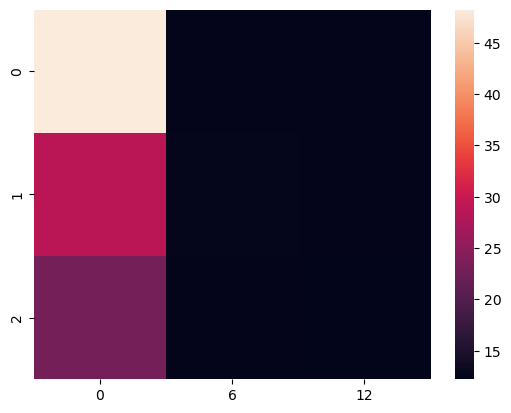

In [74]:
sns.heatmap(mae_df_arma)

<AxesSubplot:>

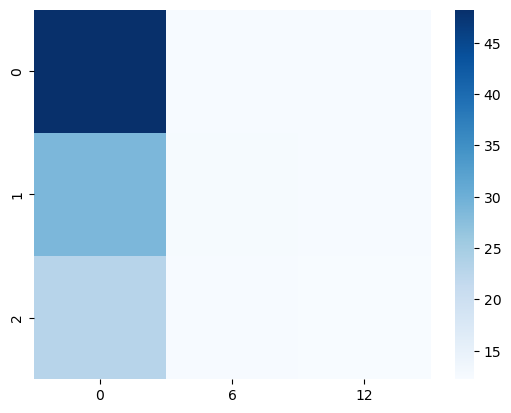

In [75]:
sns.heatmap(mae_df_arma, cmap = "Blues")

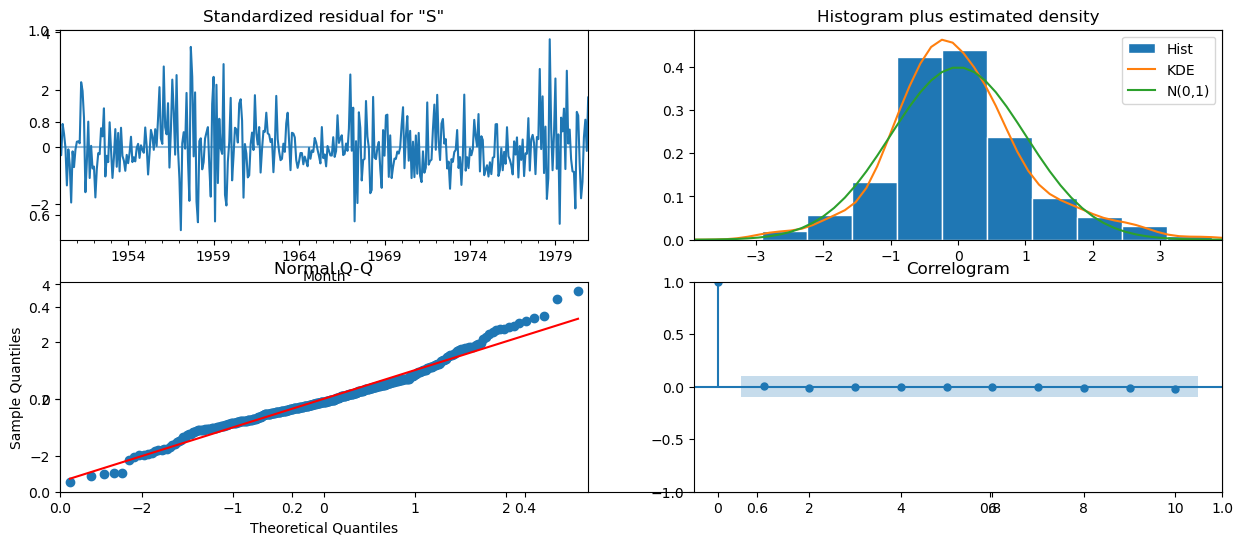

In [76]:
fig, ax = plt.subplots(figsize=(15, 6))
model_arma.plot_diagnostics(fig=fig);

In [77]:
# y_pred_wfv_arma = pd.Series()
# history_arma = y_train_arma.copy()

# for i in range(len(y_test_arma)):
#     model_arma = ARIMA(y_train_arma, order=(16,0,2)).fit()
#     next_pred = model_arma.forecast()
#     y_pred_wfv_arma = y_pred_wfv_arma.append(next_pred)
#     history_arma = history_arma.append(y_test_arma[next_pred.index])

In [78]:
# test_mae = mean_absolute_error(y_test, y_pred_wfv)
# print("Test MAE (walk forward validation):", round(test_mae, 2))